In [1]:
from airfoil import Airfoil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from panel_method import define_panels, Freestream, build_matrix, build_rhs, get_tangential_velocity, get_pressure_coefficient

In [2]:
c = 1

In [3]:
a = Airfoil('0012', 0, 400000, c)

In [4]:
airfoil = pd.read_csv('./airfoils/0012_airfoil_0_degrees.csv')

In [5]:
x = airfoil['x'].to_numpy()
y = airfoil['y'].to_numpy()

In [6]:
E = 70000
G = 26500
I = 0.036*c*a.t*(a.t**2+a.h**2)
d= a.t/2
J = np.pi * d ** 4/32
e = 0.1 * c

In [7]:
rho = 1.225
u_inf = 1
alpha = 15
freestream = Freestream(u_inf, alpha)
Npanels = 200

In [8]:
span = 5
N = 10
S = span/N*c

Text(0, 0.5, 'Y')

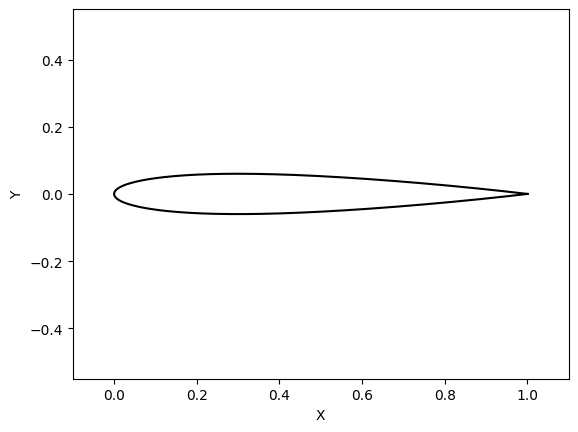

In [9]:
plt.plot(x, y, color = 'black')
plt.xlim(-.1, 1.1)
plt.ylim(-.55, .55)
plt.xlabel('X')
plt.ylabel('Y')

(-0.02, 0.02)

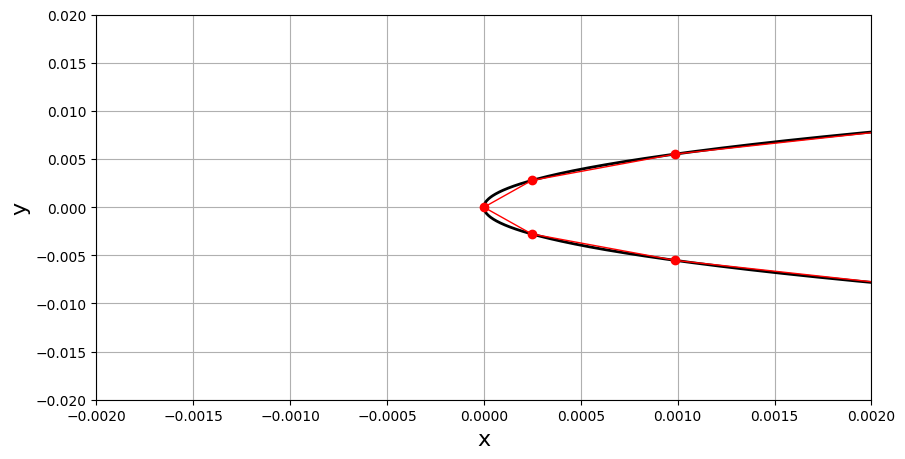

In [10]:
panels = define_panels(x, y, Npanels)

width = 10
plt.figure(figsize=(width, width/2))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linewidth=1, marker='o', markersize=6, color='red')
plt.xlim(-.002, .002)
plt.ylim(-.02, .02)

(-0.2, 0.2)

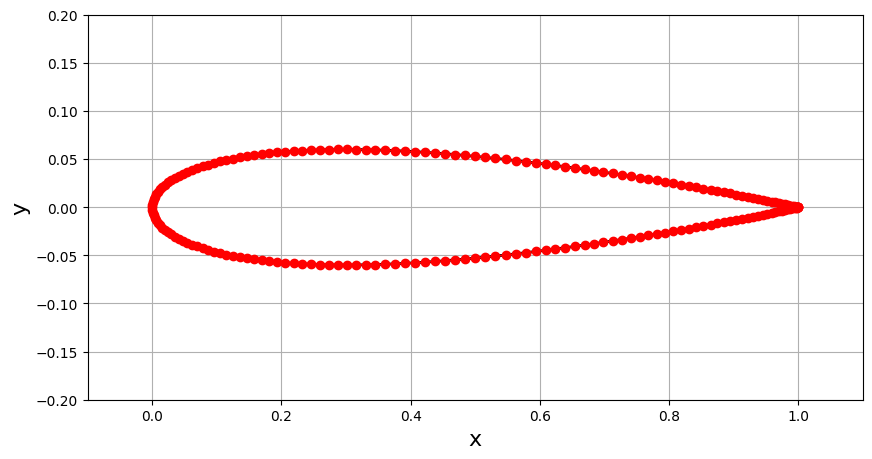

In [11]:
width = 10
plt.figure(figsize=(width, width/2))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linewidth=1, marker='o', markersize=6, color='red')
plt.xlim(-.1, 1.1)
plt.ylim(-.2, .2)

In [12]:
A = build_matrix(panels)
b = build_rhs(panels, freestream) 

In [13]:
variables = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
	panel.sigma = variables[i]
gamma = variables[-1]

In [14]:
get_tangential_velocity(panels, freestream, gamma)

In [15]:
get_pressure_coefficient(panels, freestream)

Text(0.5, 1.0, 'Number of panels : 200')

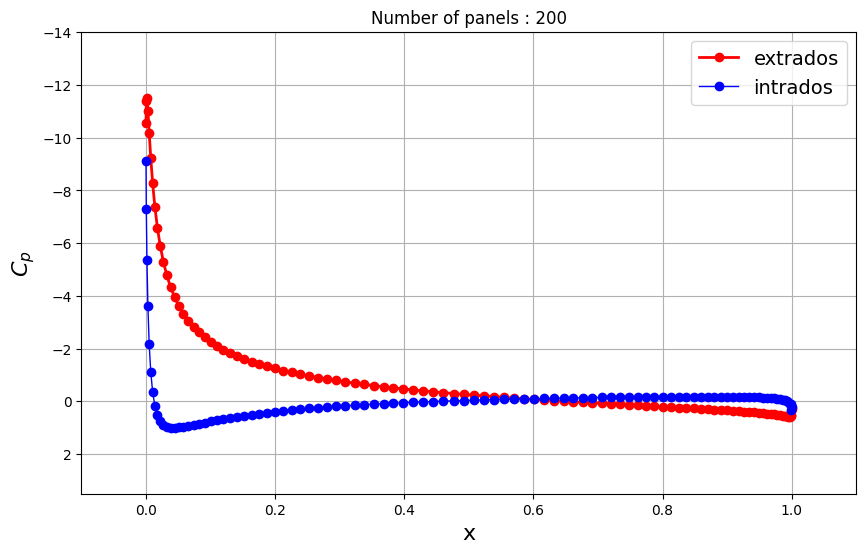

In [23]:
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'extrados'], 
         [panel.cp for panel in panels if panel.loc == 'extrados'], 
         color='r', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'intrados'], 
         [panel.cp for panel in panels if panel.loc == 'intrados'], 
         color='b', linewidth=1, marker='o', markersize=6)
plt.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.gca().invert_yaxis()
plt.title('Number of panels : %d' % Npanels)

In [17]:
accuracy = sum([panel.sigma*panel.length for panel in panels])
'--> sum of source/sink strengths:', accuracy

('--> sum of source/sink strengths:', 0.0009295388813043653)

In [18]:
cl = gamma*sum(panel.length for panel in panels)/(0.5*freestream.u_inf*(x_max-x_min))
'--> Lift coefficient: Cl = %.3f' % cl

'--> Lift coefficient: Cl = 1.839'

In [19]:
cm = sum(panel.cp*(panel.xc-0.25)*panel.length*np.cos(panel.beta) for panel in panels)
'--> Moment coefficient: Cm = %.3f' % cm

'--> Moment coefficient: Cm = -0.088'

In [20]:
L = cl * S * rho * u_inf ** 2 * 0.5

In [21]:
M = cm * S * rho * u_inf ** 2 * 0.5

In [22]:
T = M + e*L